In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import pickle
import operator
import itertools
from collections import defaultdict
import tqdm
import tskit
import numpy as np
import pyslim
import scipy.stats as stats
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt
import matplotlib as mpl

from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.utils import read_centro, BScores
from bgspy.utils import read_bkgd, midpoint, arg_nearest
from bgspy.utils import bin_chrom, get_files, BScores, exact_index
from bgspy.sim_utils import calc_b_from_treeseqs, load_b_chrom_sims 
from bgspy.theory import bgs_segment, bgs_segment_sc16
from bgspy.classic import BSC16_segment_lazy

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

# from https://writing.stackexchange.com/questions/21658/what-is-the-image-size-in-scientific-paper-if-indicated-as-a-single-1-5-or-2-c 
# in mm
mm_to_inches = lambda x: 0.0393701 * x
img_size = dict(one = mm_to_inches(90), onehalf = mm_to_inches(140), two = mm_to_inches(190))
asp_ratio = dict(golden = (1 + np.sqrt(5))/2, one=1, two=2)
fig_sizes = {(k, ar): np.round((v, v/asp_ratio[ar]), 4) for k, v in img_size.items() for ar in asp_ratio}
fig_sizes

{('one', 'golden'): array([3.5433, 2.1899]),
 ('one', 'one'): array([3.5433, 3.5433]),
 ('one', 'two'): array([3.5433, 1.7717]),
 ('onehalf', 'golden'): array([5.5118, 3.4065]),
 ('onehalf', 'one'): array([5.5118, 5.5118]),
 ('onehalf', 'two'): array([5.5118, 2.7559]),
 ('two', 'golden'): array([7.4803, 4.6231]),
 ('two', 'one'): array([7.4803, 7.4803]),
 ('two', 'two'): array([7.4803, 3.7402])}

TODO

 - nans in low rec causing issue?
 - Neh vs Ne

In [416]:
force = True

### bgspy B maps

In [417]:
w_grid = np.logspace(-10, -8, 10)
t_grid = np.logspace(-5, -1, 3)

In [445]:
t_grid

array([1.e-05, 1.e-03, 1.e-01])

In [418]:
#w_grid = np.array([1e-10, 3.16e-10, 1e-9, 3.16e-9, 1e-8, 3.16e-8])
#t_grid = np.array([0.0001, 0.000316, 0.001, 0.00316, 0.01, 0.0316, 0.1])

pkl_b_file = '../data/bmaps/bgspy/B_chr10_simple.pkl'
step = 10_000

ncores = 70

In [419]:
if force or not os.path.exists(pkl_b_file):
    g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
    g.load_annot("../data/annotation/conserved_by_chrom_features/chr10.bed")
    g.load_recmap("../data/annotation/HapMapII_GRCh37_liftedOverTo_Hg38/genetic_map_Hg38_chr10.txt")
    
    m = BGSModel(g, w_grid=w_grid, t_grid=t_grid, split_length=1_000)
    m.calc_Bp(N=1000, step=step, ncores=ncores, nchunks=200)
    m.calc_B(step=step, ncores=ncores, nchunks=70)
    m.save(pkl_b_file)
else:
    m = BGSModel.load(pkl_b_file)
    g = m.genome

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr10.
looking up map positions...	done.
calculating SC16 components...	done.
Genome divided into 200 chunks to be processed on 70 CPUs...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:29<00:00,  6.87it/s]


Genome divided into 70 chunks to be processed on 70 CPUs...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:05<00:00, 12.82it/s]


In [420]:
m.segments.feature_map

{'CDS': 0, 'phastcons': 1}

In [421]:
bp = m.BpScores
b = m.BScores

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


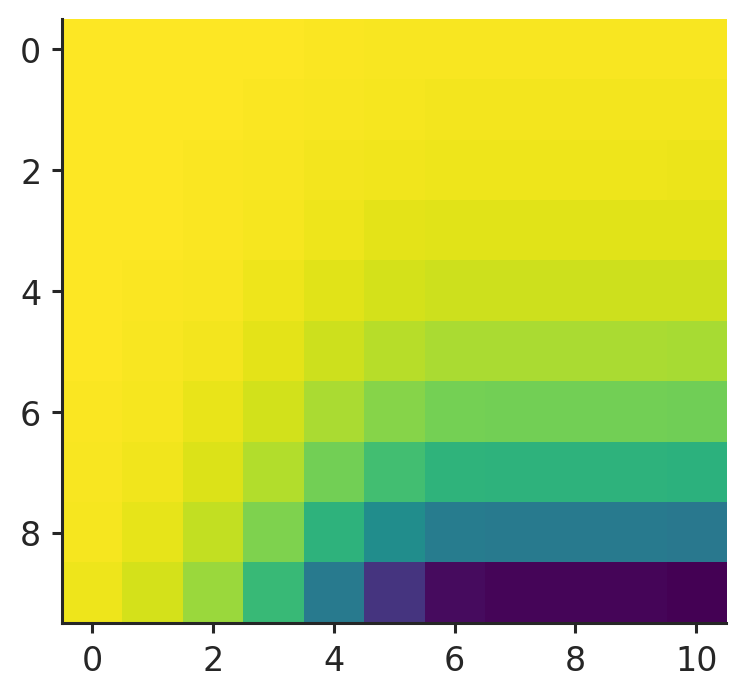

In [10]:
plt.imshow(b.B['chr10'][7_000, :, :, 0])

### `calc_bkgd` maps

In [46]:
bkgd_dir = '../data/bmaps/calc_bkgd/'
cached_bkgd1k_file = os.path.join(bkgd_dir, "calc_bkgd_1000.pkl")
mcvb = BScores.load(cached_bkgd1k_file)


In [47]:
sim_B = np.load('../data/slim_sims/chrombgs_chr10/chr10_B_sims.npz', allow_pickle=True)

In [48]:
mus = sim_B['mu']
shs = sim_B['sh']

In [49]:
mus, shs

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

In [50]:
simb_pos = (sim_B['pos'][1:] + sim_B['pos'][:-1])/2

In [51]:
sims_means = BScores({'chr10': np.log(sim_B['mean'])}, {'chr10': simb_pos}, mus, shs, step=None)
sims_sds = BScores({'chr10': np.log(sim_B['sd'])}, {'chr10': simb_pos}, mus, shs, step=None)

In [52]:
from bgspy.utils import bin_chrom
bin_chrom(g.seqlens['chr10'], 1000)

array([        0,      1000,      2000, ..., 133796000, 133797000,
       133797422], dtype=uint32)

In [56]:
# sh = 0.01
# mu = 3.16e-9

# f, ax = plt.subplots()

# x, y = sims_means['chr10', mu, sh]
# lines = ax.plot(x/1e6, y, label='sims')
# sim_pos, sd = sims_sds['chr10', mu, sh]
# _, mean = sims_means['chr10', mu, sh]
# ax.fill_between(sim_pos/1e6, mean - sd, mean + sd, alpha=0.4, 
#                  linewidth=0, color=lines[0].get_color())
# x, y = b['chr10', mu, sh]

# ax.plot(x/1e6, y, label='bgspy classic', zorder=2)

# x, y = bp['chr10', mu, sh]
# ax.plot(x/1e6, y, label='bgspy')

# ax.legend(ncol=2)


## Simulation Data

In [506]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
g.load_annot("../data/annotation/conserved_phastcons_thresh5_slop1k_chr10.bed")
g.load_recmap("../data/annotation/HapMapII_GRCh37_liftedOverTo_Hg38/genetic_map_Hg38_chr10.txt")

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)


In [517]:
gd = GenomeData(g)
gd.load_dac_file('../data/chrombgs_chr10_N1000_mu1e-08_sh0.01_chr10_seed1080912304_rep53_dac.tsv.gz')
gd.load_neutral_masks('../data/annotation/neutral_cds_phastcons.bed')

ERROR! Session/line number was not unique in database. History logging moved to new session 1592


In [508]:
sim_pi = gd.bin_pi(width=1e6, filter_accessible=False)

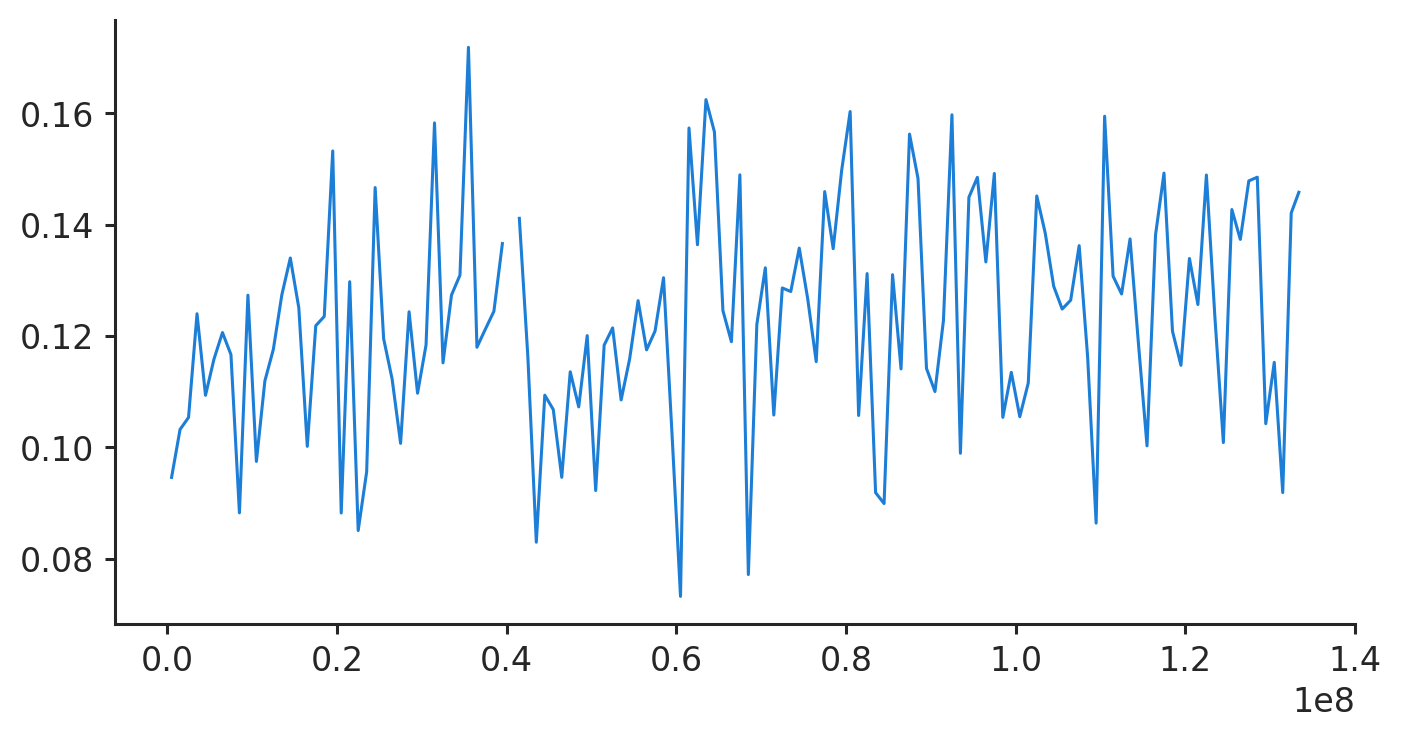

In [513]:
x, y = sim_pi[1]['chr10'].pairs
plt.plot(x, y)
#plt.plot(*pi['chr10'].pairs)

In [533]:
import msprime
ts = tskit.load('../data/chrombgs_chr10_N1000_mu1e-08_sh0.01_chr10_seed1080912304_rep53_treeseq.tree')

In [537]:
rts = ts.delete_sites([m.site for m in ts.mutations()])

In [543]:
msprime.sim_mutations(rts, rate=1e-7).num_mutations

522080

In [546]:
msprime.sim_mutations(rts, rate=1e-6, discrete_genome=True).num_mutations

5224202

In [522]:
gd.npoly(True, False)

{'chr10': 413719}

## Genome Data

In [547]:
from bgspy.data import GenomeData
gd = GenomeData(g)
gd.load_counts_dir('../data/hg1k_counts/')
gd.load_neutral_masks('../data/annotation/neutral_cds_phastcons.bed')
gd.load_accessibile_masks('../data/annotation/no_centro.bed')

In [549]:
gd.npoly(True, True)

{'chr10': 41988358}

In [182]:
scale = 1e6

In [183]:
bins_alt, pi_alt = gd.bin_pi(width=scale, filter_neutral=False, filter_accessible=False)

In [184]:
bins, pi = gd.bin_pi(width=scale, filter_neutral=True, filter_accessible=True)

In [185]:
m.w, m.t

(array([1.00000000e-10, 1.66810054e-10, 2.78255940e-10, 4.64158883e-10,
        7.74263683e-10, 1.29154967e-09, 2.15443469e-09, 3.59381366e-09,
        5.99484250e-09, 1.00000000e-08]),
 array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]))

In [491]:
_, d = gd.bin_reduce(scale, True, False)

In [492]:
Y = d['chr10'].stat[1:, ...] ## TODO off by one

In [496]:
B = bp.bin_means(bins)['chr10'].stat

In [497]:
b.B['chr10'].shape

(13381, 10, 3, 2)

In [190]:
from itertools import product

def loglik(pi0, B, Y):
    pibar = pi0 * np.exp(B)
    nS = Y[:, 0][:, None, None, None]
    nD = Y[:, 1][:, None, None, None]
    ll = nD * np.log(pibar) + nS * np.log(1-pibar)
    lls = ll.sum(axis=0)
    nw, nt = B.shape[1], B.shape[2]
    wi, ti = np.arange(nw), np.arange(nt)
    nf = B.shape[3]
    wt = list(product(wi, ti))
    xi = list(product(*[wt for _ in range(nf)]))
    comb_lls = np.zeros(len(xi))
    for i, row in enumerate(xi):
        for j, pair in enumerate(row):
            comb_lls[i] += lls[pair[0], pair[1], j]
    return comb_lls, xi

def loglik_interpol(pi0, B, Y, w):
    pibar = pi0 * np.exp(B)
    nS = Y[:, 0][:, None, None, None]
    nD = Y[:, 1][:, None, None, None]
    ll = nD * np.log(pibar) + nS * np.log(1-pibar)
    lls = ll.sum(axis=0)
    # interpolate the dfe weights for each selcoef
    nf = lls.shape[2]
    nt = B.shape[2]
    interpols = [None] * nf
    for i in range(nf):
        interpols[i] = [None] * nt
        for j in range(nt):
            y = lls[:, j, i]
            assert(len(w) == len(y))
            interpols[i][j] = interpolate.interp1d(w, y, kind='quadratic', bounds_error=False, fill_value=-np.Inf)
            
    def ll_func(x):
        ll = 0
        x = x.reshape(nt, nf)
        for i in range(nf):
            for j in range(nt):
                # TODO fix for multiple features
                ll += interpols[i][j](x[j, i])
        return -ll
    return ll_func



def pred(pi0, B, ml_xi):
    Bc = np.array([B[:, wi, ti, i] for i, (wi, ti) in enumerate(ml_xi)])
    pibar = pi0 * np.exp(Bc.sum(axis=0))
    return pibar

In [436]:
def interpol_Bw(B, w):
    nl, nw, nt, nf = B.shape
    interpols = defaultdict(dict)
    for l in range(nl):
        for i in range(nf):
            interpols[l][i] = [None] * nt
            for j in range(nt):
                y = B[l, :, j, i]
                assert(len(w) == len(y))
                interpols[l][i][j] = interpolate.interp1d(w, y, kind='quadratic', bounds_error=False, fill_value='extrapolate')
    def B_func(x):
        x = x.reshape(nt, nf)
        Bo = np.zeros((B.shape[0], B.shape[2], B.shape[3]))
        for l in range(nl):
            for i in range(nf):
                for j in range(nt):
                    val = np.exp(interpols[l][i][j](x[j, i]))
                    val = min(1, val)
                    val = max(0, val)
                    Bo[l, j, i] = np.log(val)
        return Bo
    return B_func


def loglik2(pi0, B, w, Y):
    Bfunc = interpol_Bw(B, w)
    nS = Y[:, 0][:, None]
    nD = Y[:, 1][:, None]
    nl, nw, nt, nf = B.shape
    
    def func(x):
        pibar = pi0 * np.exp(Bfunc(x).sum(axis=1))
        ll = nD * np.log(pibar) + nS * np.log(1-pibar)
        lls = ll.sum(axis=0)
        return lls.sum()
    return func

loglik2(1.4e-3, B, m.w, Y)(np.random.uniform(1e-9, 1e-8, nf*m.t.size)[:, None]).shape

()

In [437]:
llfunc = loglik2(2e-3, B, m.w, Y)


In [438]:
bf = interpol_Bw(B, m.w)

In [498]:
minimize(llfunc, np.random.uniform(1e-10, 1e-8, nf*m.t.size)[:, None], method='Nelder-Mead', bounds=[(1e-10, 1e-8)] * nf*m.t.size).x.reshape((m.t.size, -1))

array([[1.e-10, 1.e-10],
       [1.e-10, 1.e-10],
       [1.e-10, 1.e-10]])

In [444]:
minimize(llfunc, np.random.uniform(1e-10, 1e-8, nf*m.t.size)[:, None], method='Nelder-Mead', bounds=[(1e-10, 1e-8)] * nf*m.t.size).x.reshape((m.t.size, -1))

array([[1.e-10, 1.e-10],
       [1.e-10, 1.e-10],
       [1.e-10, 1.e-10]])

In [410]:
m.t

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01])

In [447]:
llfunc = loglik2(2e-3, B, m.w, Y)

res = []
for i in range(50):
    xx = minimize(llfunc, np.random.uniform(1e-10, 1.1e-8, nf*m.t.size)[:, None], method='L-BFGS-B', bounds=[(1e-10, 1.1e-8)] * nf*m.t.size).x.reshape(m.t.size, -1)
    res.append(xx)


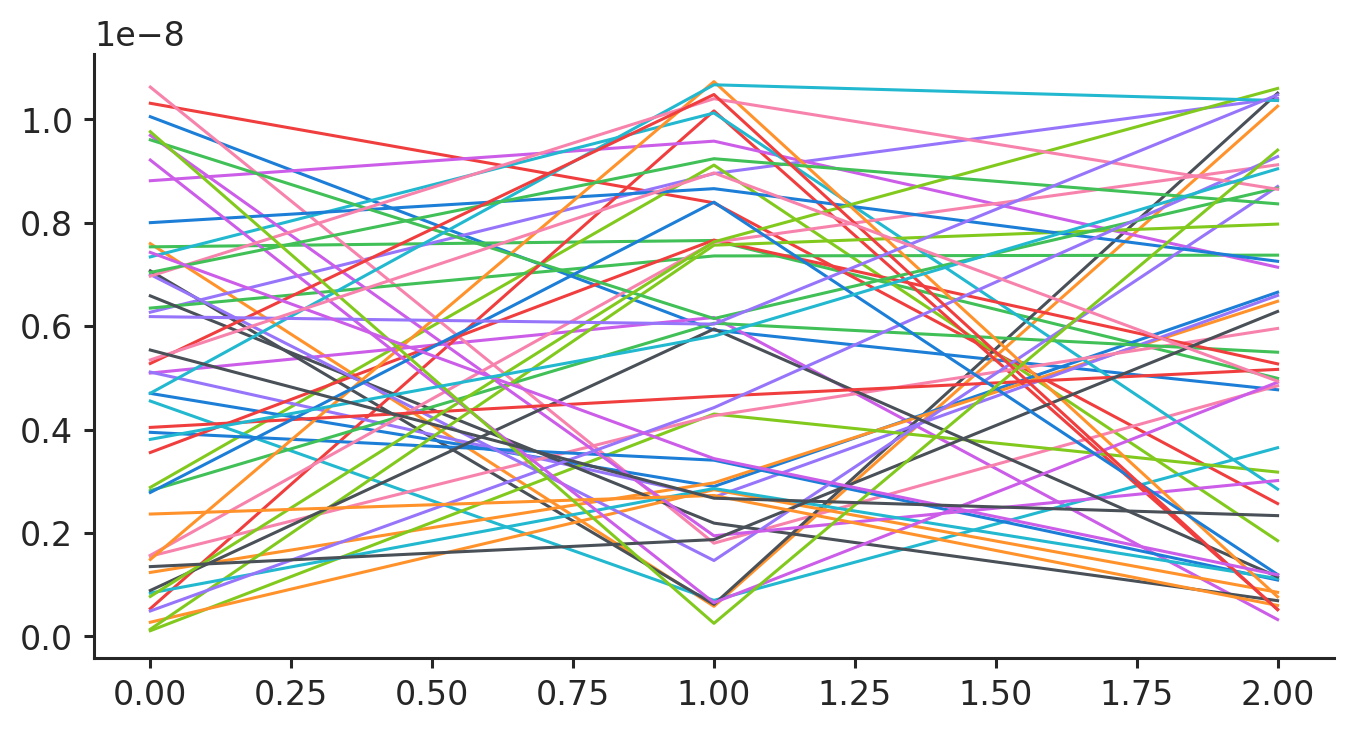

In [448]:
_ = plt.plot(np.array(res)[:, :, 0].T)

In [321]:
x = np.logspace(-10, -8, 5)[:, None]
np.exp(interpol_Bw(B[:, :, :, 0][:, :, :, None], m.w)(x)).shape

(134, 5, 1)

In [258]:
np.exp(interpol_Bw(B, m.w)(np.random.uniform(1e-9, 1e-8, nf*m.t.size)[:, None])).shape

(134, 5, 2)

In [220]:
B.shape

(134, 10, 5, 2)

In [208]:
nf = B.shape[3]
func = loglik_interpol(1.5e-3, B, Y, m.w)
func(np.random.uniform(1e-9, 1e-8, nf*m.t.size)[:, None])

1791730502222.379

In [222]:
res = []
for i in range(40):
    res.append(minimize(func, np.random.uniform(1e-9, 1e-8, nf*m.t.size)[:, None], method='L-BFGS-B', bounds=[(1e-10, 1e-8)] * nf*m.t.size).x)

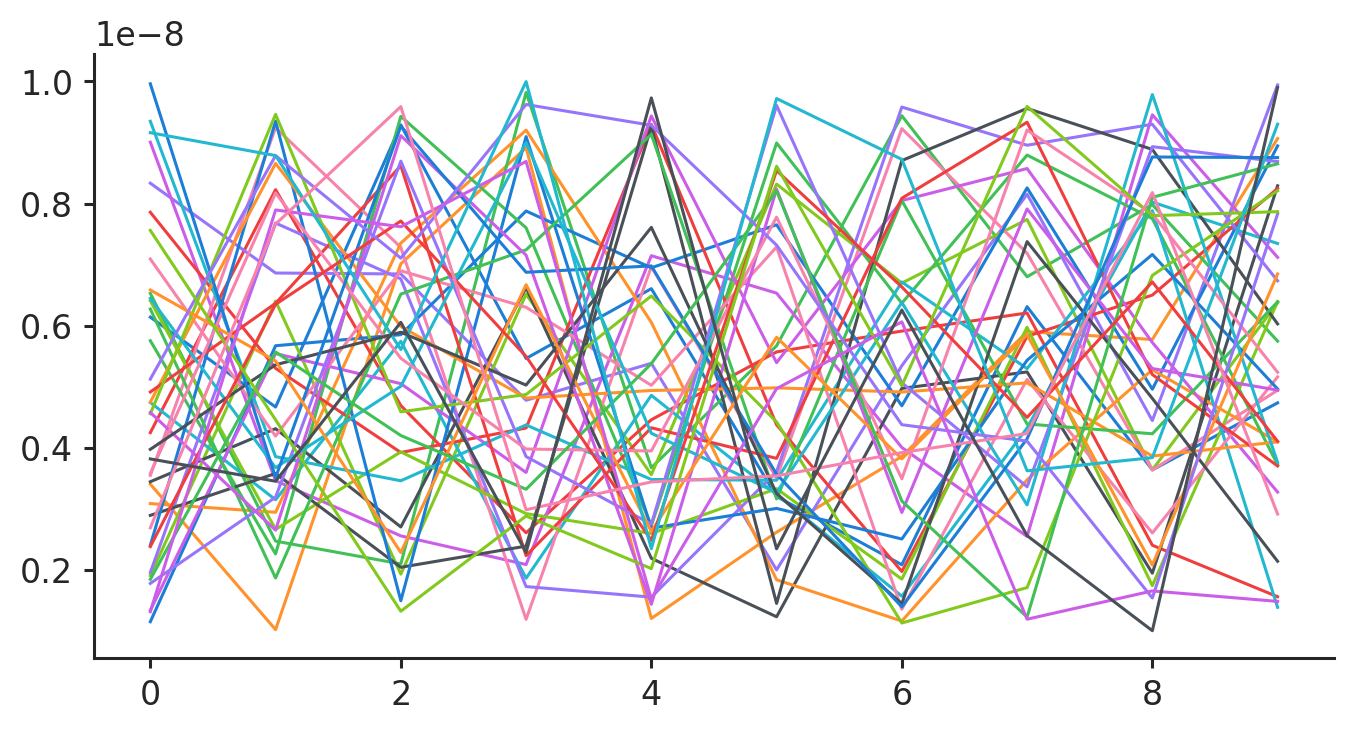

In [223]:
_ =plt.plot(np.array(res).T)

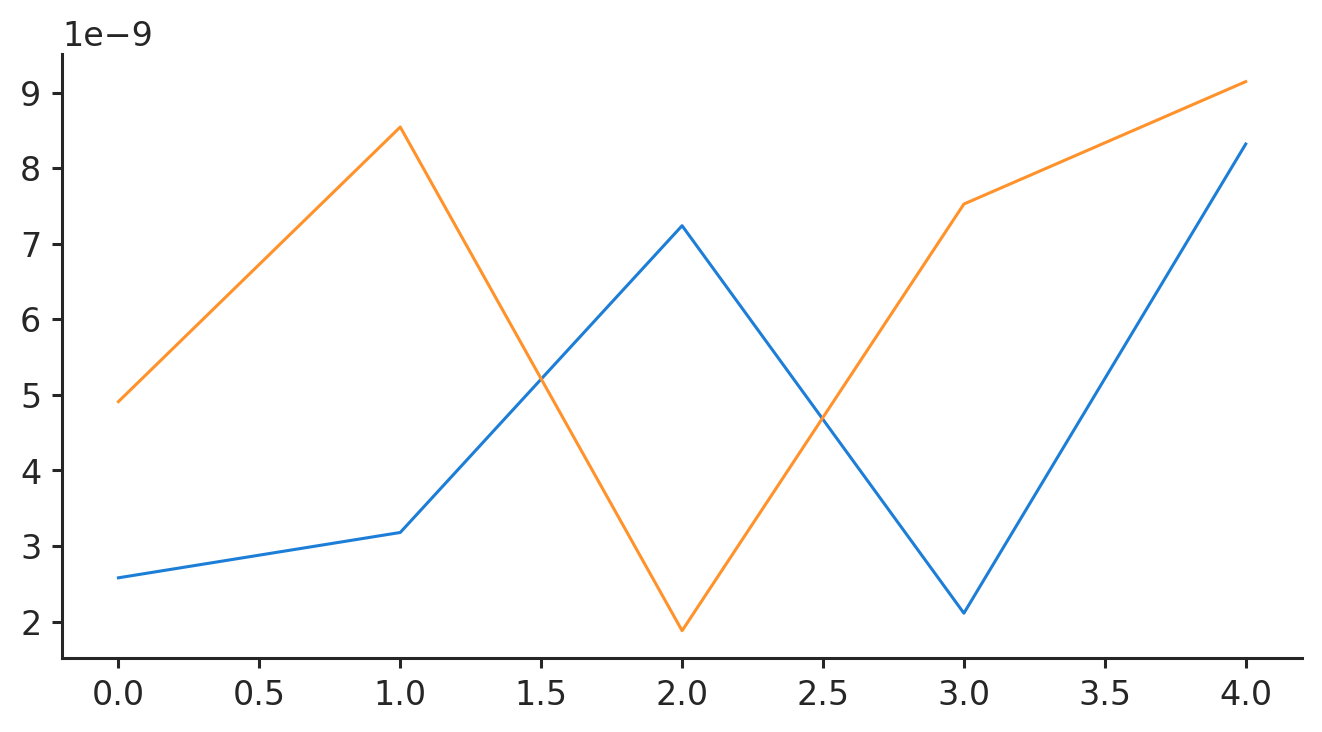

In [226]:
plt.plot(minimize(func, np.random.uniform(1e-9, 1e-8, nf*m.t.size)[:, None],method='L-BFGS-B', bounds=[(1e-10, 1e-8)] * nf*m.t.size).x.reshape(m.t.size, nf))

In [138]:
from scipy.optimize import minimize

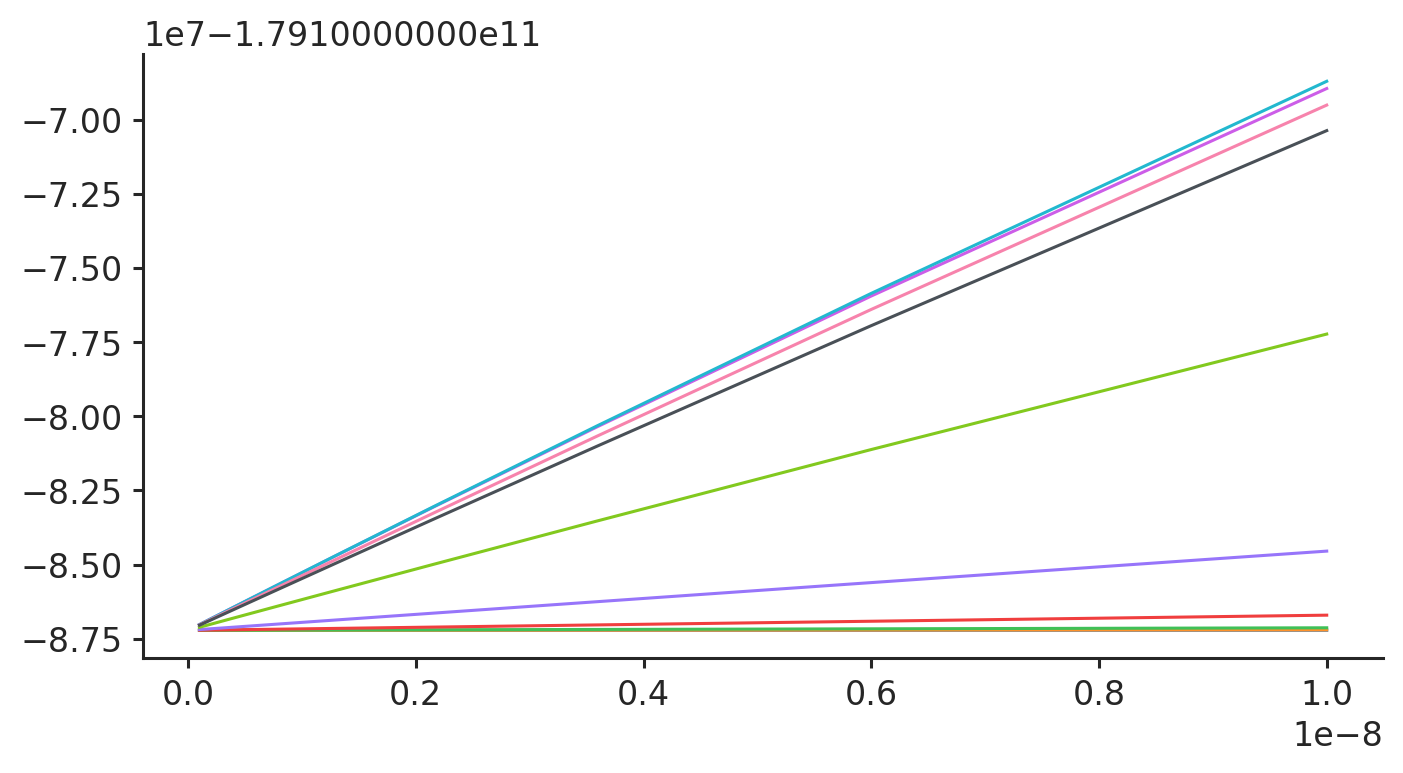

In [115]:
x = np.logspace(-10, -8, 10)

for i in range(10):
    plt.plot(x, loglik_interpol(1.5e-3, B[:, :, :, 0][:, :, :, None], Y, m.w)[0][i](x))

In [102]:
debug

> /tmp/ipykernel_45299/2087851150.py(35)loglik_interpol()
     33             y = lls[:, j, i]
     34             assert(len(w) == len(y))
---> 35             interpols[i][j] = interpolate.interp1d(w, y, kind='quadratic')
     36     return interpols
     37 



ipdb>  interpols


[None, None, None, None, None, None, None, None, None, None, None]


ipdb>  exit


In [101]:
pi0 = 1e-3
pibar = pi0 * np.exp(B)
nS = Y[:, 0][:, None, None, None]
nD = Y[:, 1][:, None, None, None]
ll = nD * np.log(pibar) + nS * np.log(1-pibar)
lls = ll.sum(axis=0)
lls.shape

(10, 11, 3)

In [501]:
gwpi = gd.gwpi()
pi0s = np.logspace(np.log10(gwpi), -1, 10)
lls = [np.max(loglik(pi0, B, Y)[0]) for pi0 in pi0s]

0.12024038071999027


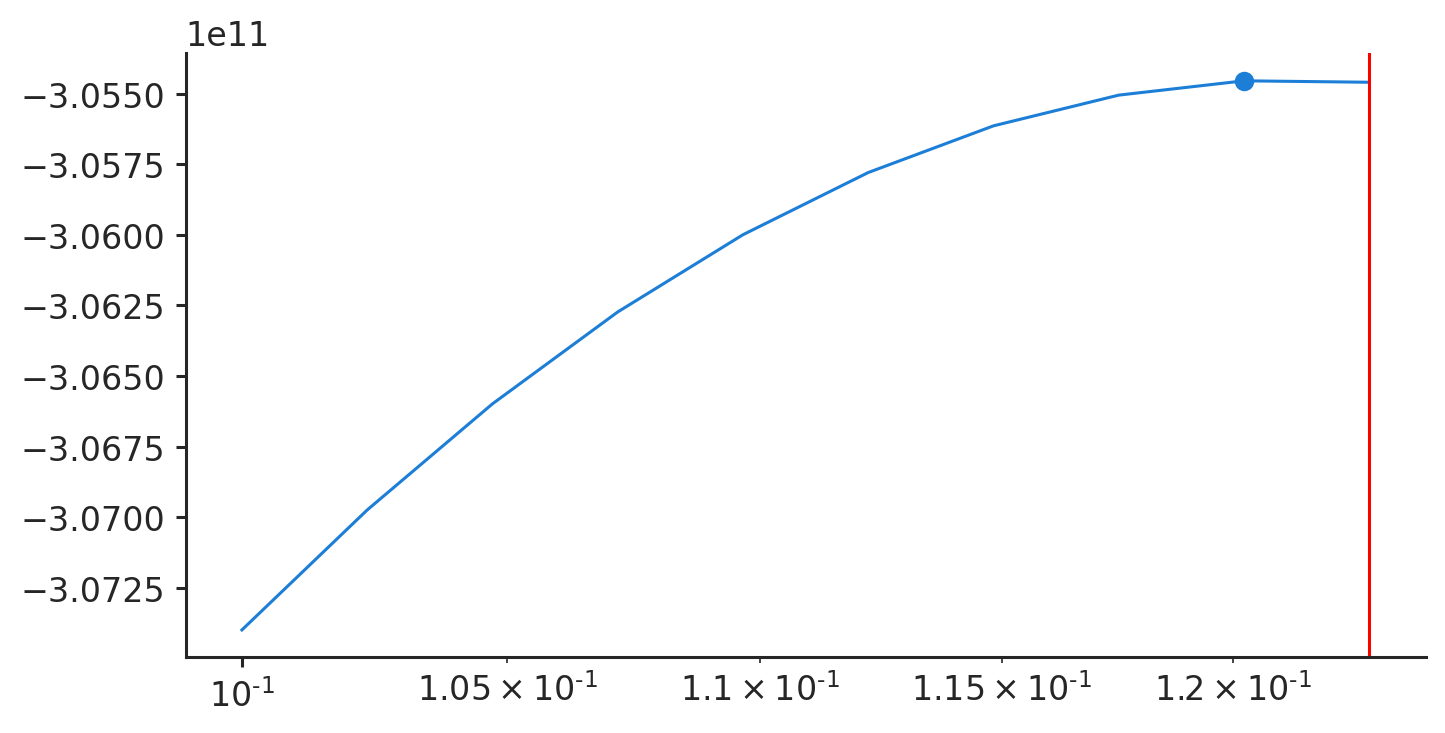

In [502]:
plt.plot(pi0s, lls)
plt.semilogx()
plt.scatter(pi0s[np.argmax(lls)], np.max(lls))
plt.axvline(gwpi, c='r')
print(pi0s[np.argmax(lls)])

In [503]:
ml_pi0 = pi0s[np.argmax(lls)]

In [504]:
ll, xi = loglik(ml_pi0, B, Y)

In [505]:
[(m.w[i], m.t[j]) for i, j in xi[np.argmax(ll)]]

[(1e-10, 1e-05), (1e-10, 1e-05)]

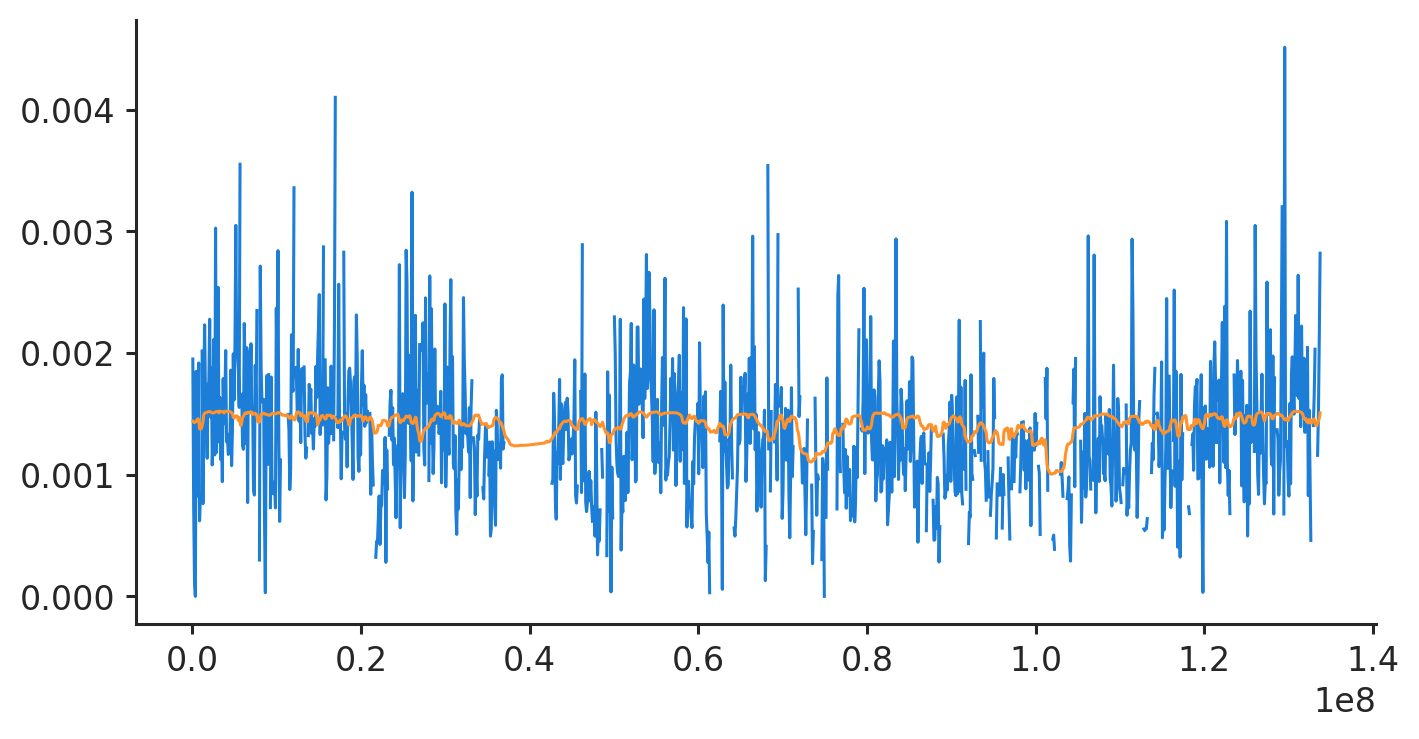

In [71]:
plt.plot(*pi['chr10'].pairs)
#plt.plot(*pi_alt['chr10'].pairs)
plt.plot(pi['chr10'].midpoints, pred(ml_pi0, B,  xi[np.argmax(ll)]))

In [112]:
b.w, b.t

(array([1.00000000e-10, 1.66810054e-10, 2.78255940e-10, 4.64158883e-10,
        7.74263683e-10, 1.29154967e-09, 2.15443469e-09, 3.59381366e-09,
        5.99484250e-09, 1.00000000e-08]),
 array([1.00000000e-05, 2.51188643e-05, 6.30957344e-05, 1.58489319e-04,
        3.98107171e-04, 1.00000000e-03, 2.51188643e-03, 6.30957344e-03,
        1.58489319e-02, 3.98107171e-02, 1.00000000e-01]))

In [113]:
m.w[xi[np.argmax(ll)][0][0]], m.t[xi[np.argmax(ll)][0][1]]

(1e-08, 0.006309573444801936)

0.0013899017116029277


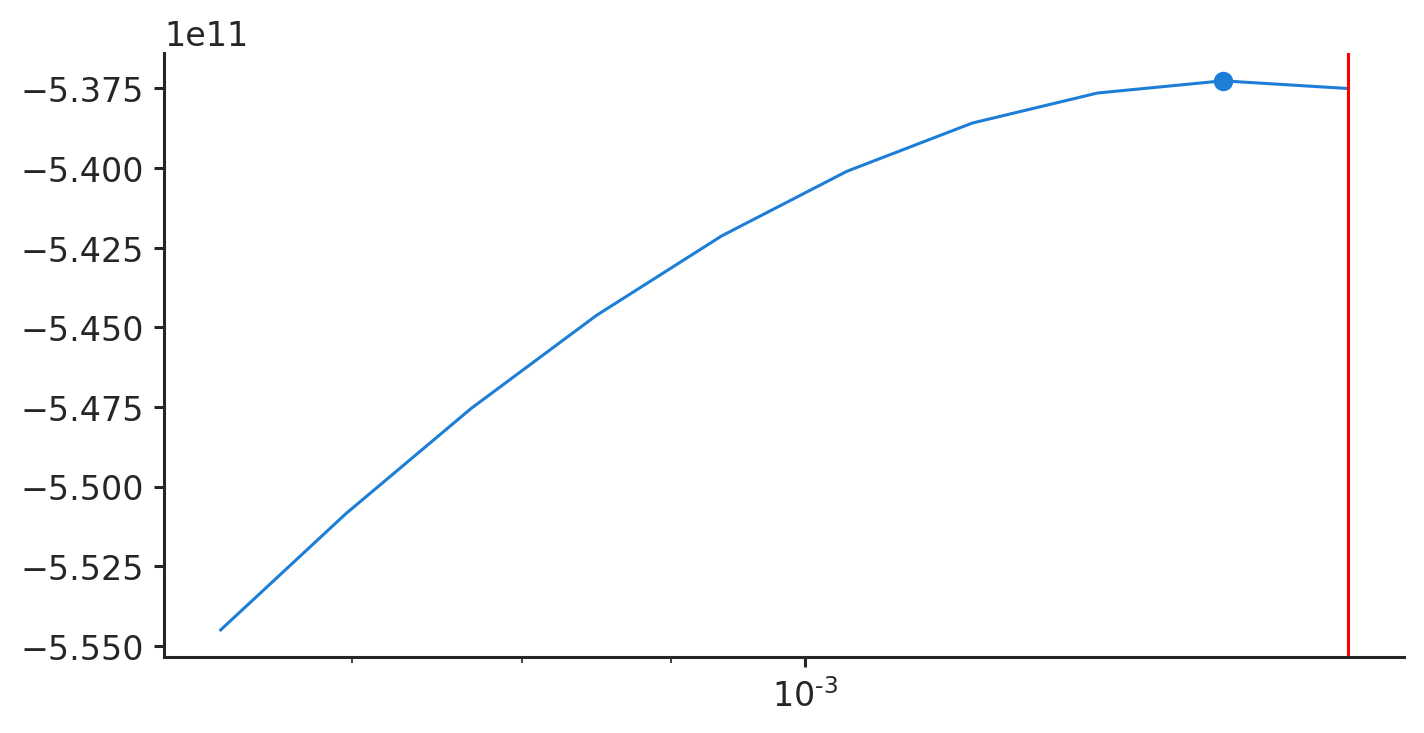

In [280]:
plt.plot(pi0s, lls)
plt.semilogx()
plt.scatter(pi0s[np.argmax(lls)], np.max(lls))
plt.axvline(gd.gwpi(), c='r')
print(pi0s[np.argmax(lls)])

In [153]:
pi0

0.0007943282347242813

In [133]:
lls = loglik(0.001859, B, Y).sum(axis=0)

In [134]:
lls.shape

(10, 11, 3)

In [135]:
from itertools import product

In [136]:
wti = list(product(np.arange(m.w.size), np.arange(m.t.size)))

In [137]:
wt = list(product(m.w, m.t))

In [138]:
xi = list(product(wti, wti, wti))

In [139]:
x = list(product(wt, wt, wt))

In [140]:
len(x)

1331000

In [141]:
comb_lls = np.zeros(len(x))
for i, row in enumerate(xi):
    for j, pair in enumerate(row):
        comb_lls[i] += lls[pair[0], pair[1], j].sum()

In [142]:
x[np.argmax(comb_lls)]

((1e-08, 6.309573444801929e-05),
 (1e-08, 6.309573444801929e-05),
 (1e-08, 2.5118864315095822e-05))

In [104]:
m.segments.feature_map

{'CDS': 0, 'UTR': 1, 'phastcons': 2}

In [36]:
lls[..., 0]a

array([[-5.27013715e+11, -5.27012621e+11, -5.27011723e+11,
        -5.27010949e+11, -5.27010492e+11, -5.27010300e+11,
        -5.27010223e+11],
       [-5.27023308e+11, -5.27019798e+11, -5.27016943e+11,
        -5.27014488e+11, -5.27013041e+11, -5.27012433e+11,
        -5.27012189e+11],
       [-5.27054453e+11, -5.27042825e+11, -5.27033598e+11,
        -5.27025739e+11, -5.27021132e+11, -5.27019200e+11,
        -5.27018424e+11],
       [-5.27160197e+11, -5.27118451e+11, -5.27087417e+11,
        -5.27061727e+11, -5.27046871e+11, -5.27040678e+11,
        -5.27038199e+11],
       [-5.27561634e+11, -5.27385391e+11, -5.27269725e+11,
        -5.27180191e+11, -5.27130280e+11, -5.27109807e+11,
        -5.27101666e+11],
       [-5.29320600e+11, -5.28457280e+11, -5.27951917e+11,
        -5.27597111e+11, -5.27412270e+11, -5.27339113e+11,
        -5.27310484e+11]])

In [35]:
np.kron(np.exp(lls[..., 0]), np.exp(lls[..., 1]))

FloatingPointError: underflow encountered in exp

In [313]:
plt.imshownp.einsum('ijkl->jkl', ll).shape

(30, 31, 3)

In [257]:
from scipy import optimize
from scipy import interpolate

In [258]:
pi0s = np.logspace(-3.1, -2.2, 1000)
lls = [np.max(loglik(pi0, B, Y)[:, :, 0]) for pi0 in pi0s]

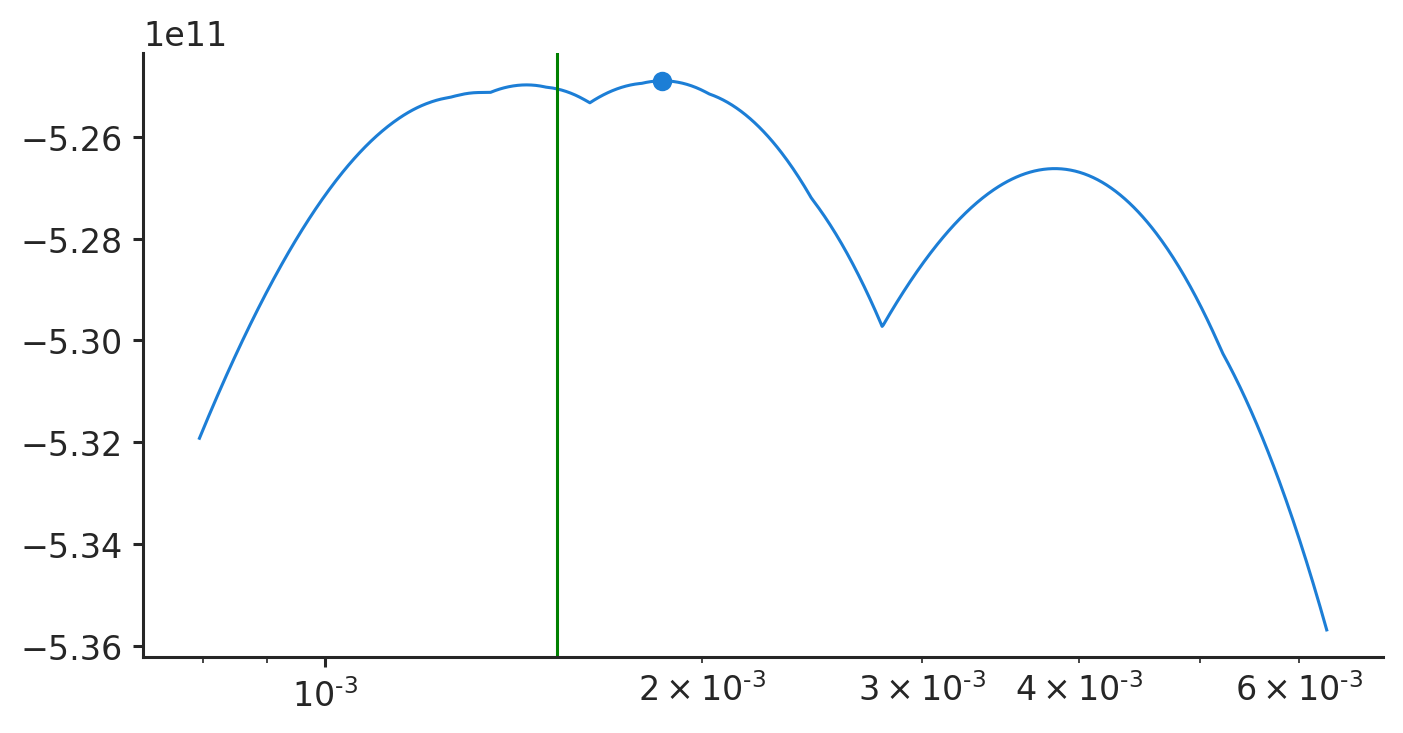

In [259]:
plt.plot(pi0s, lls)
plt.semilogx()
plt.scatter(pi0s[np.argmax(lls)], np.max(lls))
plt.axvline(np.nanmean(a), c='g')

In [163]:
gd.gwpi()

0.0015341121197713313

In [ ]:
a

In [260]:
pi0s[np.argmax(lls)]

0.0018593851980811505

In [272]:
a, n = gd.pi()

In [273]:
a.values()

dict_values([0.0015341121197713313])

In [274]:
np.fromiter(a.values(), dtype='float'), np.fromiter(n.values(), dtype='float')

(array([0.00153411]), array([1.31876659e+08]))

In [276]:
np.average(np.fromiter(a.values(), dtype='float'), weights=np.fromiter(n.values(), dtype='float'))

0.0015341121197713313

In [265]:
np.average(*a['chr10'])

TypeError: tuple indices must be integers or slices, not str

In [235]:
np.nanmean(a)

0.0015341121197713313

In [230]:
gd.counts['chr10']

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int16)

In [248]:
ll = loglik(pi0s[np.argmax(lls)], B, Y)[:, :, 0]

In [249]:
m.w, m.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

In [250]:
wi, ti = np.where(np.max(ll) == ll)

In [251]:
m.w[wi], m.t[ti]

(array([3.16e-09]), array([0.0316]))

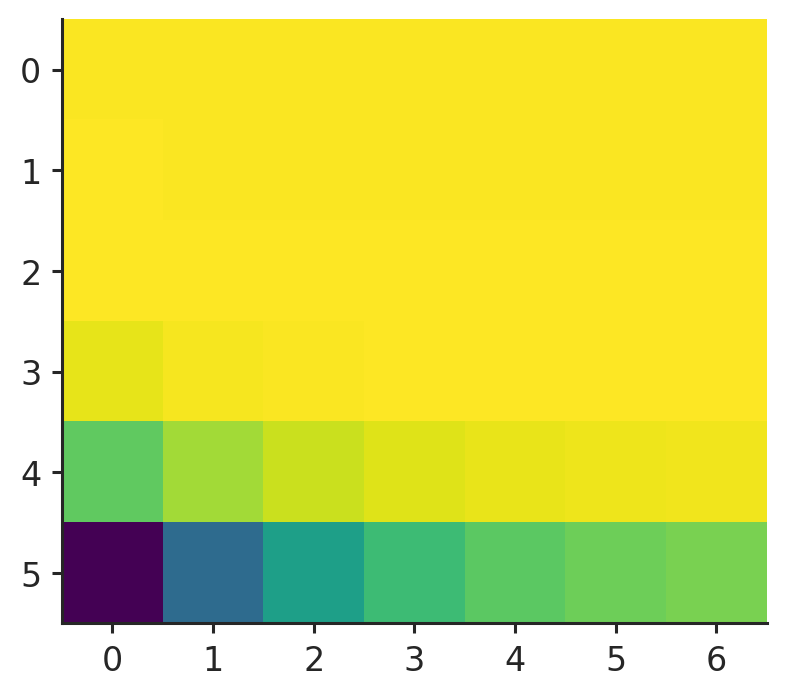

In [252]:
plt.imshow(ll)

In [245]:
B = b.bin_means(bins)['chr10'].stat

In [70]:
B.shape, Y.shape

((134, 6, 7, 1), (135, 2))

In [71]:
nS = Y[1:, 0].squeeze()

In [72]:
nS.shape

(134,)

In [75]:
B.shape

(134, 6, 7, 1)

In [77]:
(nS[:, None, None, None] * np.log(1-np.exp(B))).shape

(134, 6, 7, 1)

In [ ]:
loglik(0.001, B, Y)

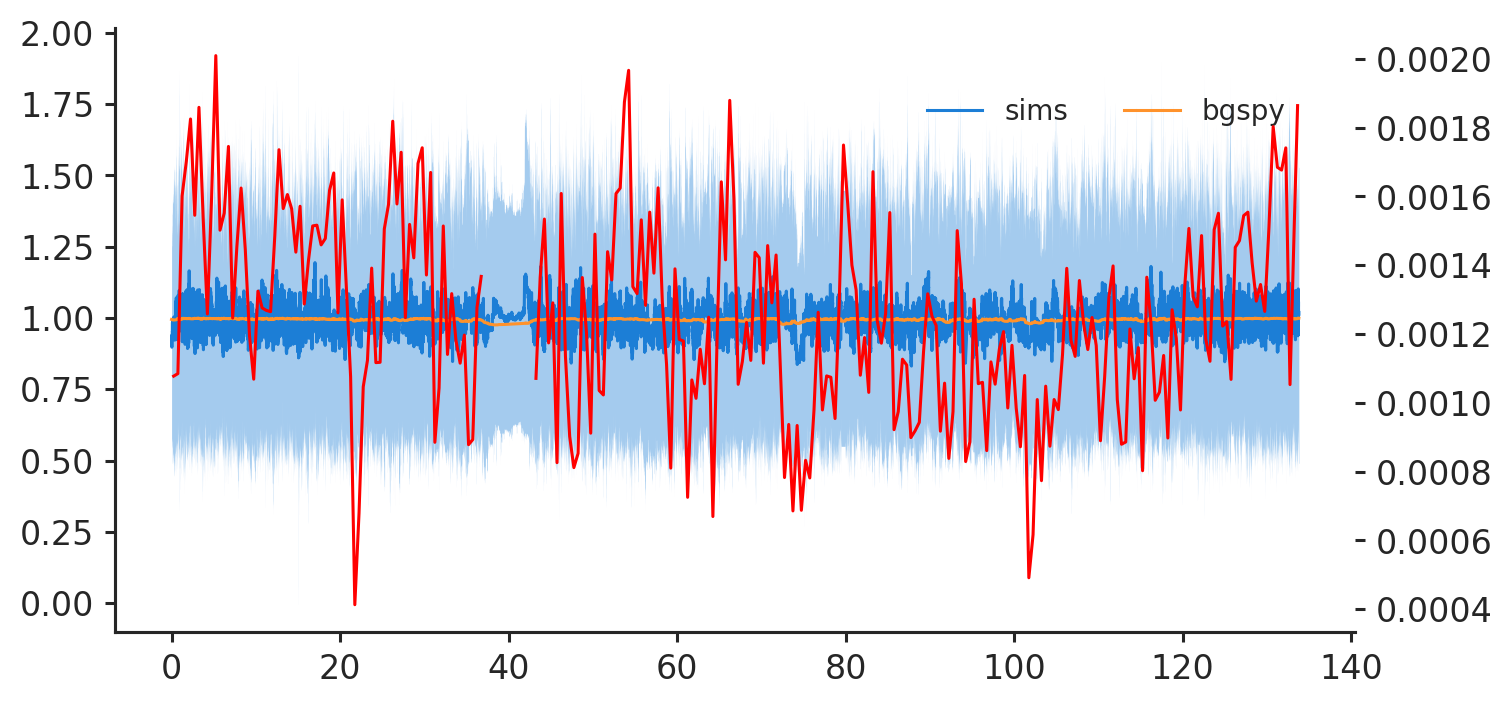

In [84]:
sh = 0.0001
mu = 3.16e-9

f, ax = plt.subplots()

ax2 = ax.twinx()
x, y = sims_means['chr10', mu, sh]
lines = ax.plot(x/1e6, y, label='sims')
sim_pos, sd = sims_sds['chr10', mu, sh]
_, mean = sims_means['chr10', mu, sh]
ax.fill_between(sim_pos/1e6, mean - sd, mean + sd, alpha=0.4, 
                 linewidth=0, color=lines[0].get_color())

b = 0.5*(bins['chr10'][:-1] + bins['chr10'][1:])
y = pi['chr10'][1:]
y[np.abs(b - 40e6) < 3e6] = np.nan
ax2.plot(b/1e6, y, zorder=2, c='r')


x, y = bp['chr10', mu, sh]
ax.plot(x/1e6, y, label='bgspy')

ax.legend(ncol=2)


In [36]:
from bgspy.utils import GenomicBins

a = GenomicBins(g.seqlens, 1e6)

In [37]:
%%time
r = b.bin_means(a)

CPU times: user 77.1 ms, sys: 8.91 ms, total: 86 ms
Wall time: 85.1 ms


In [ ]:
r

{'chr10': BinnedStat(shape: 134×6×7×1, bin width: 1000000)}

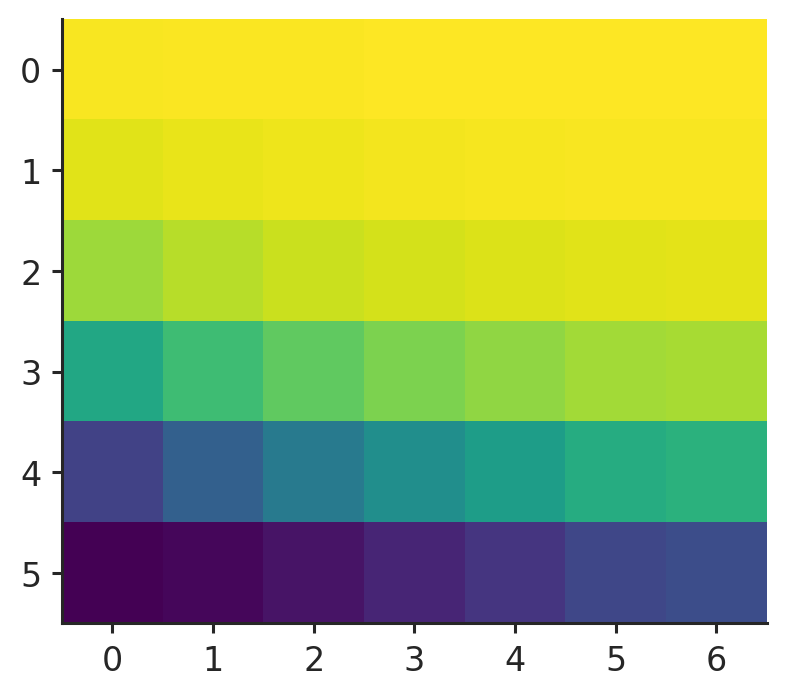

In [56]:
plt.imshow(np.exp(r['chr10'].stat)[1, :, :, 0])

In [58]:
(6 * 6)**4 * 8/1e9

0.013436928

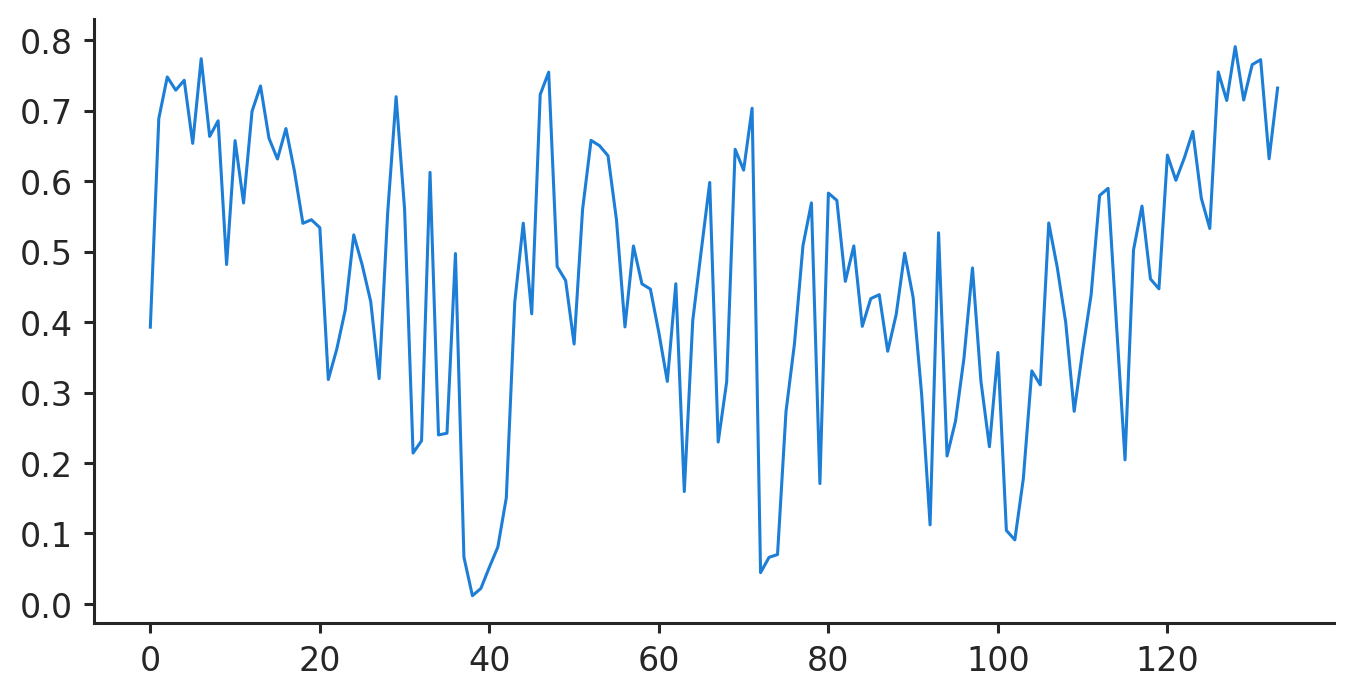

In [151]:
plt.plot(np.exp(a.aggregate_positions(b.B, b.pos, np.mean, axis=0)['chr10'])[:, 3, 1, 0])

In [140]:
debug


> /home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py(554)binned_statistic_dd()
    552     # Make sure that `values` is 2D to iterate over rows
    553     values = np.atleast_2d(values)
--> 554     Vdim, Vlen = values.shape
    555 
    556     # Make sure `values` match `sample`



ipdb>  values.shape


(133799, 6, 7, 1)


ipdb>  exit


In [132]:
np.digitize(b.pos['chr10'], a['chr10'])

array([  1,   1,   1, ..., 134, 134, 134])

In [133]:
b.pos['chr10']

array([        0,      1000,      2000, ..., 133796000, 133797000,
       133797421], dtype=uint32)

In [128]:
b.bin_means(a)['chr10'].shape

> /home/vsb/projects/bprime/bgspy/utils.py(106)bin_means()
    104             trapezoid = 0.5 * (y[1:, ...] + y[:-1, ...])
    105             __import__('pdb').set_trace()
--> 106             means[chrom] = np.average(trapezoid, axis=0, weights=width)
    107         return means
    108 



ipdb>  width


array([1000, 1000, 1000, ..., 1000, 1000,  421], dtype=uint32)


ipdb>  exit


BdbQuit: 

In [125]:
a

GenomicBins: 1,000,000bp windows on 1 chromosomes
  chr10: [0, 1000000, 2000000, ..., 132000000, 133000000, 133797422]

In [112]:
x = bp.pos['chr10']
y = bp.B['chr10']

In [116]:
y.shape

(133799, 6, 7, 1)

In [117]:
0.5 * (x[1:] - x[:-1]) * (y[1:, ...] + y[:-1, ...])


(133798, 6, 7, 1)

In [102]:
np.empty((20, 20, 10), dtype=np.float32).nbytes

16000

building interpolators...		done.
building interpolators...		done.


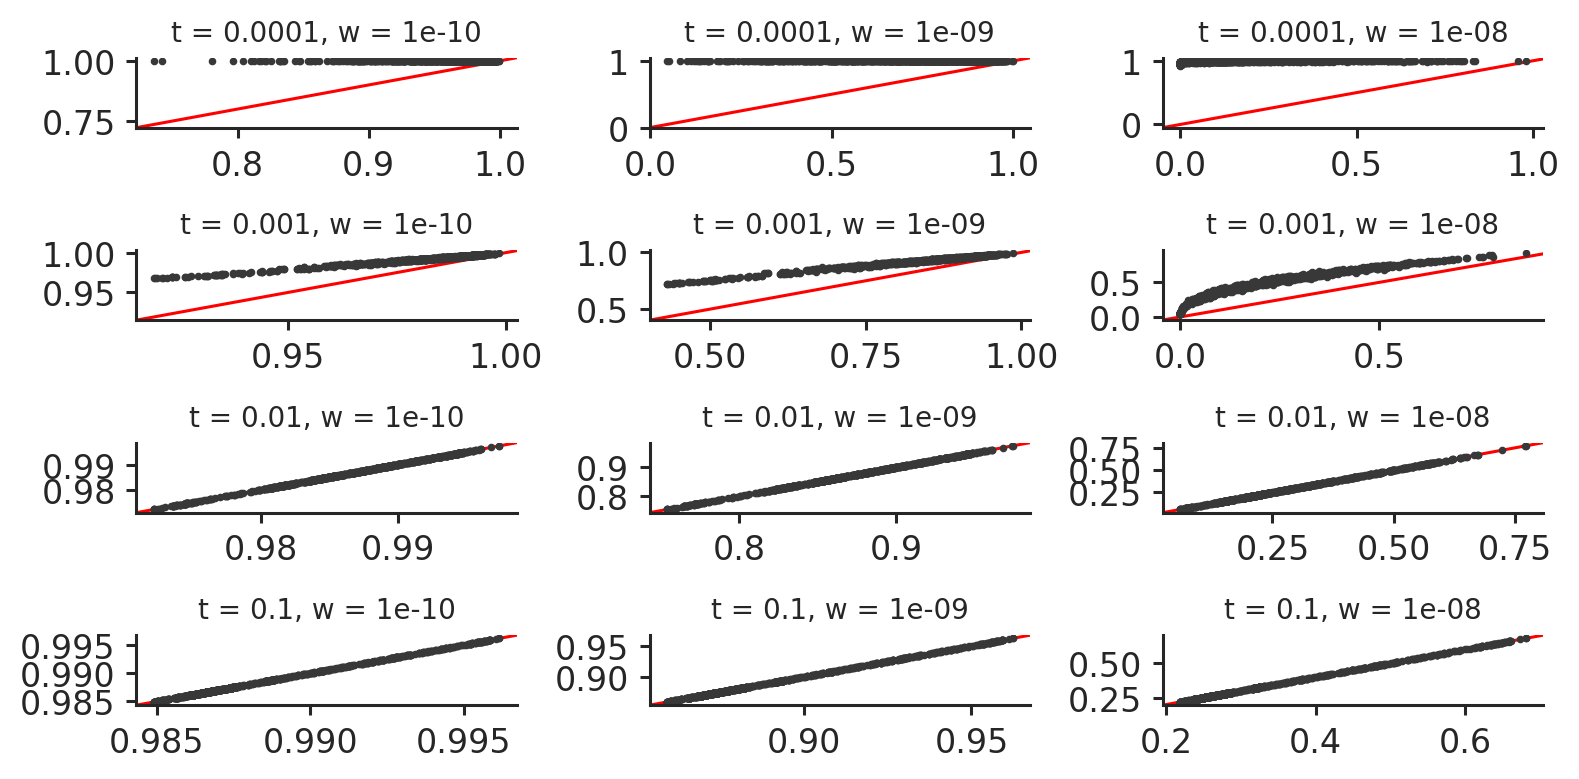

In [26]:
sh = 0.1
mu = 2.e-10

facet_mus = np.array([1.e-10, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
pos = np.random.choice(sim_pos, 1000)

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr)

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    x = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    y = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]

    ax[j, i].scatter(x, y, s=3, c='0.22')
    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='r', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=10)
    
plt.tight_layout()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


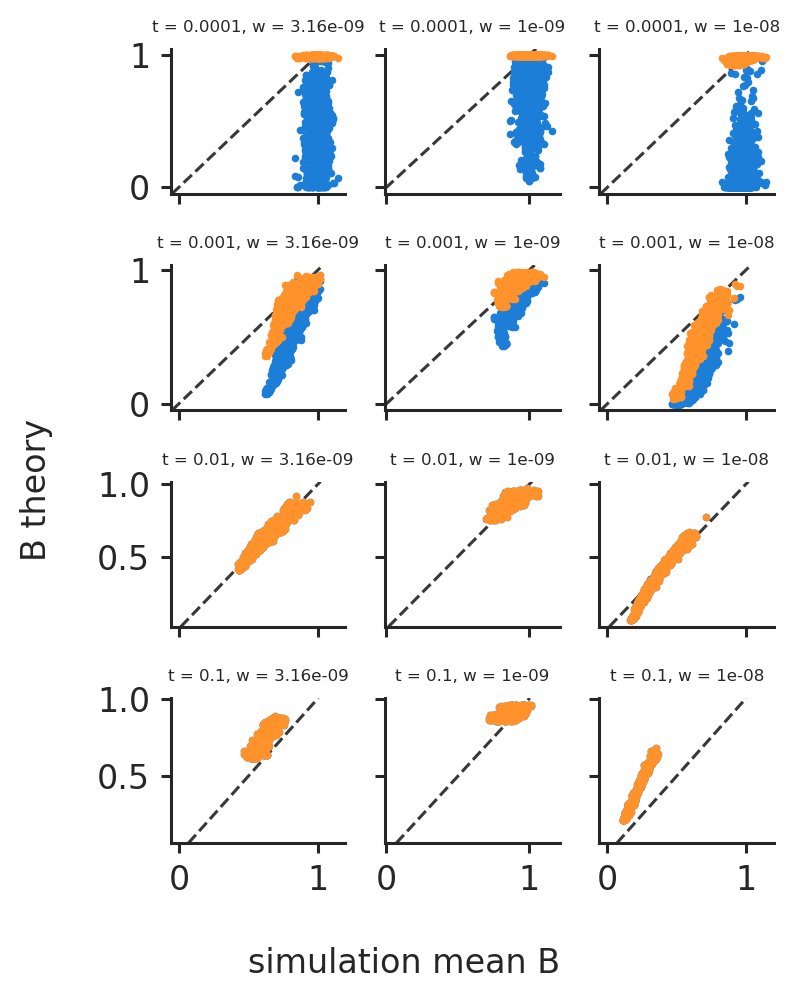

In [30]:
facet_mus = np.array([3.16e-09, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
n = 1000
idx = np.random.randint(0, len(sim_pos), n)
pos = sim_pos[idx]

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr, sharex='col', sharey='row', figsize=(4, 5))

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    y = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    ya = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    x = sims_means['chr10', mu, sh][1][idx]
    
    ax[j, i].scatter(x, y, s=3)
    ax[j, i].scatter(x, ya, s=3)

    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='0.22', linestyle='dashed', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=6)
    o = 0
    #ax[j, i].set_xlim(o, 1.01)
    #ax[j, i].set_ylim(o, 1.01)
    #if i == 0:
    #    ax[j, i].set_ylabel("B theory")
    #if j == nr:
    #    ax[j, i].set_xlabel("simulation mean B")


f.supxlabel('simulation mean B')
f.supylabel('B theory')

plt.tight_layout()

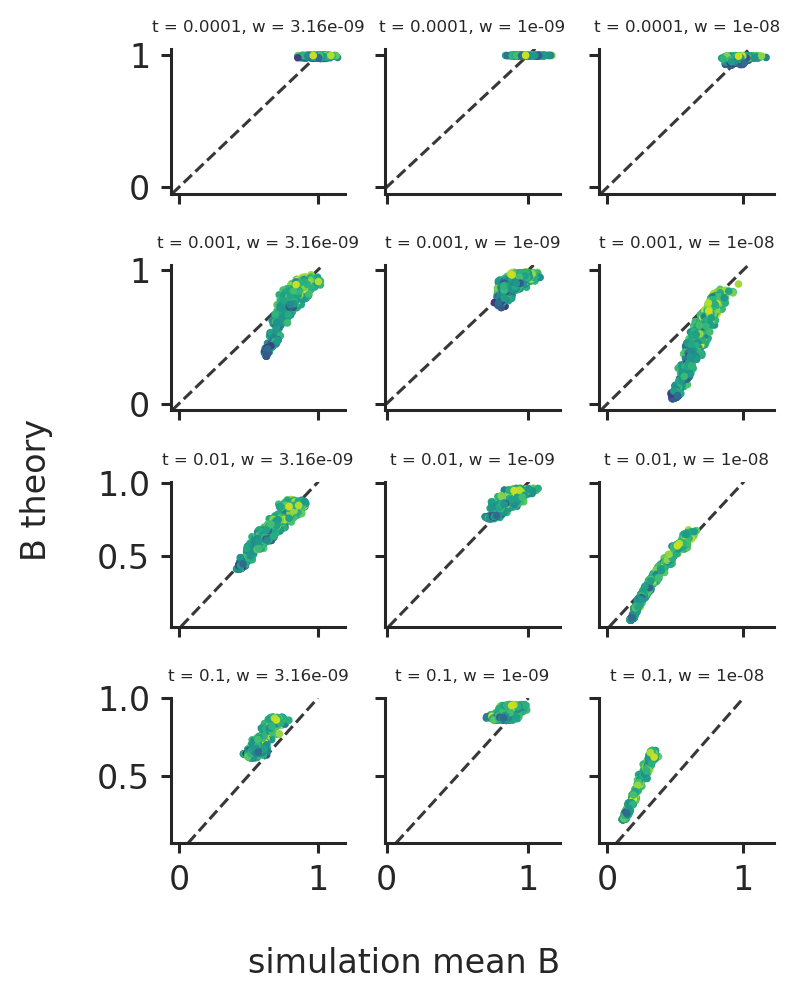

In [66]:
facet_mus = np.array([3.16e-09, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
n = 1000
idx = np.random.randint(0, len(sim_pos), n)
pos = sim_pos[idx]

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr, sharex='col', sharey='row', figsize=(4, 5))

all_sim, all_bsc = [], []
all_s, all_mu = [], []
all_pos = []

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    y = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    ya = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    x = sims_means['chr10', mu, sh][1][idx]
    
    ax[j, i].scatter(x, ya, s=3, c=g.recmap.lookup('chr10', pos), norm=mpl.colors.LogNorm())
    all_s.extend([sh]*len(x))
    all_mu.extend([mu]*len(x))
    all_sim.extend(x.tolist())
    all_pos.extend(pos.tolist())
    all_bsc.extend(ya.tolist())
    #ax[j, i].scatter(x, ya, s=3)

    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='0.22', linestyle='dashed', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=6)
    o = 0
    #ax[j, i].set_xlim(o, 1.01)
    #ax[j, i].set_ylim(o, 1.01)
    #if i == 0:
    #    ax[j, i].set_ylabel("B theory")
    #if j == nr:
    #    ax[j, i].set_xlabel("simulation mean B")


f.supxlabel('simulation mean B')
f.supylabel('B theory')

plt.tight_layout()

In [153]:
from bgspy.utils import load_bed_ranges
from bgspy.plots import surface_plot, chrom_plot

In [266]:
f = "../data/chrombgs_chr10_N1000_mu1e-08_sh0.001_chr10_seed1001729303_rep17_dac.tsv.gz"

m.load_dacfile(f, load_bed_ranges('../data/annotation/neutral_chr10.bed'))

0 sites in non-neutral regions skipped.


In [263]:
m.Y

{'chr10': array([[1020025.,  978975.],
        [1969225.,   29775.],
        [1937961.,   61039.],
        ...,
        [1762876.,  236124.],
        [1997001.,    1999.],
        [1993009.,    5991.]])}

In [265]:
b.pos

defaultdict(list,
            {'chr10': array([        0,      1000,      2000, ..., 133796000, 133797000,
                    133797421], dtype=uint32)})

In [165]:
pi0 = 4*1000*1.5e-8
pi0

5.9999999999999995e-05

In [273]:
llc, pi0c = m.loglikelihood(1e6, pi0=4*1000*1.5e-8, method='classic')

building interpolators...		done.
> /home/vsb/projects/bprime/bgspy/likelihood.py(135)calc_loglik_components()
    133             Y_binned[chrom] = np.stack((ndiff + nsame_fixed, ndiff)).T
    134             __import__('pdb').set_trace()
--> 135             pi_win[chrom] = ndiff / (ndiff + nsame_fixed)
    136     return Y_binned, win_Bs, pi_win
    137 



ipdb>  Y_binned[chrom].shape


(134, 2)


ipdb>  exit


BdbQuit: 

In [271]:
debug

> /home/vsb/projects/bprime/bgspy/likelihood.py(54)loglik()
     52     nD = y[:, 1, None, None]
     53     nS = y[:, 0, None, None]
---> 54     a = np.log(pi)*nD
     55     b = np.log1p(-pi)*nS
     56     assert(np.all(np.isfinite(a) | np.isnan(a)))



ipdb>  pi.shape


(6, 7, 134)


ipdb>  nD.shape


(134, 1, 1)


ipdb>  nD


array([[[23536159.]],

       [[23935633.]],

       [[28338204.]],

       [[23097498.]],

       [[26159183.]],

       [[24718074.]],

       [[19353414.]],

       [[11820085.]],

       [[11258056.]],

       [[15295632.]],

       [[20364588.]],

       [[13506120.]],

       [[12922906.]],

       [[17294489.]],

       [[18644306.]],

       [[16923844.]],

       [[14541812.]],

       [[10395853.]],

       [[13062211.]],

       [[12576100.]],

       [[18541760.]],

       [[10720522.]],

       [[ 9074880.]],

       [[18123015.]],

       [[ 9678242.]],

       [[20932259.]],

       [[15867569.]],

       [[14393297.]],

       [[19603373.]],

       [[25408183.]],

       [[17018370.]],

       [[20802331.]],

       [[31890768.]],

       [[21077579.]],

       [[17162286.]],

       [[10910698.]],

       [[21751603.]],

       [[16089935.]],

       [[18992379.]],

       [[33015664.]],

       [[33056767.]],

       [[32671047.]],

       [[25345020.]],

       [[20

ipdb>  exit


In [80]:
ll, pi0 = m.loglikelihood(pi0=4*1000*1.5e-8)

In [151]:
np.sum(ll, axis=0).shape, m.w.shape, m.t.shape

((6, 7), (6,), (7,))

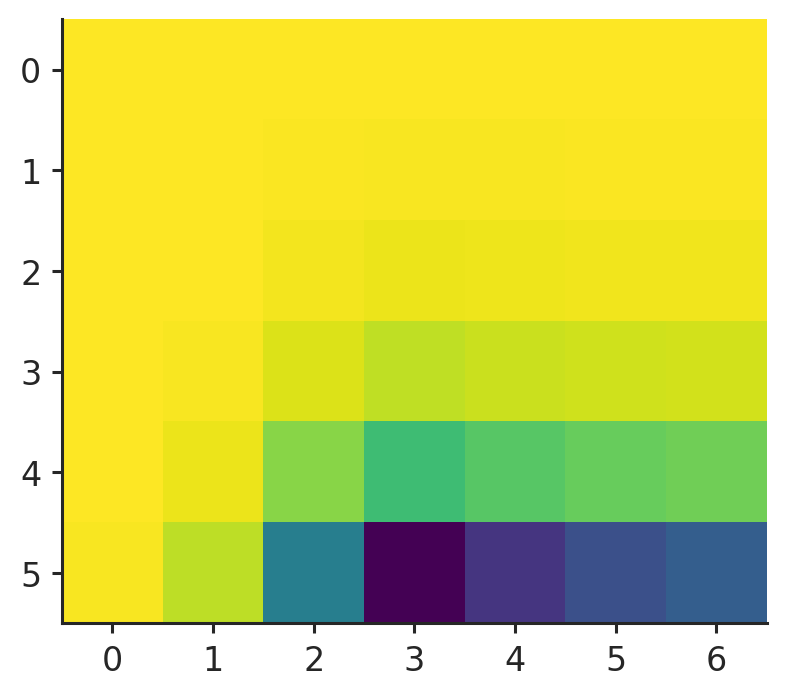

In [152]:
plt.imshow(np.sum(ll, axis=0))

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot:>)

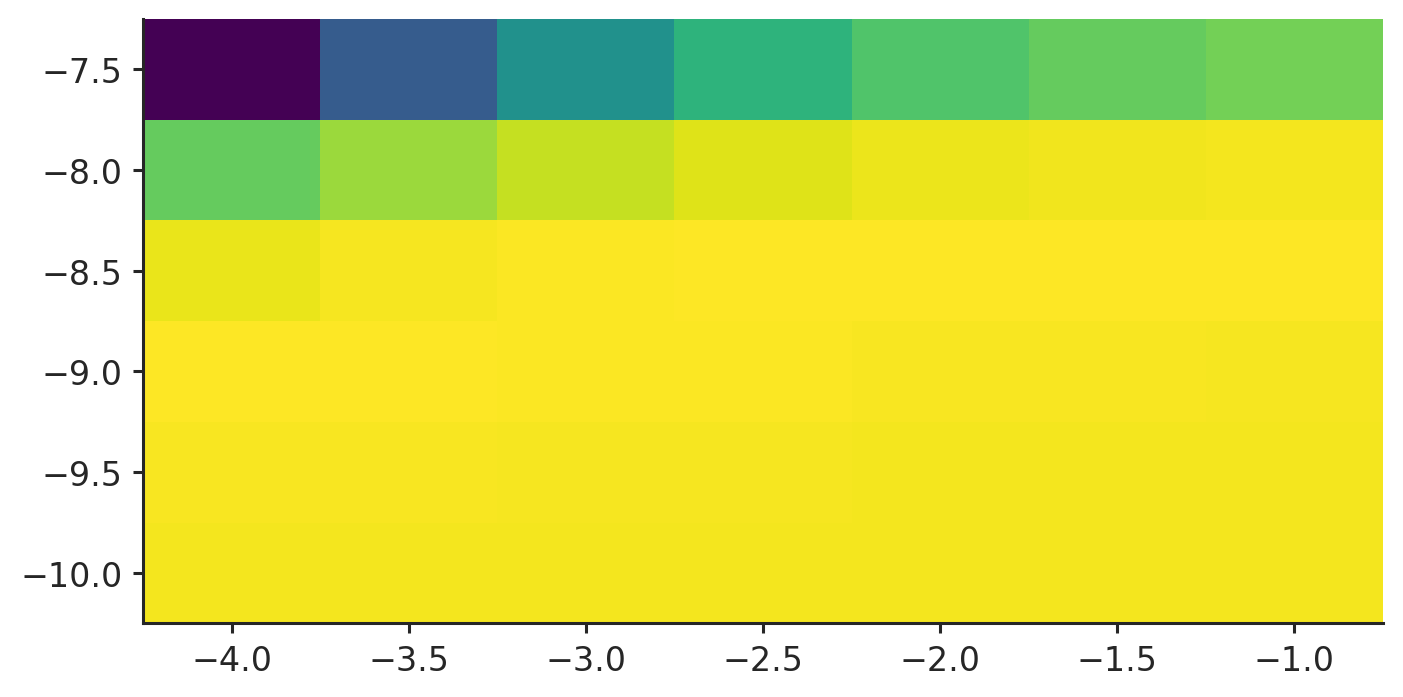

In [111]:
surface_plot(np.log10(m.t), np.log10(m.w), np.sum(llc, axis=0))

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot:>)

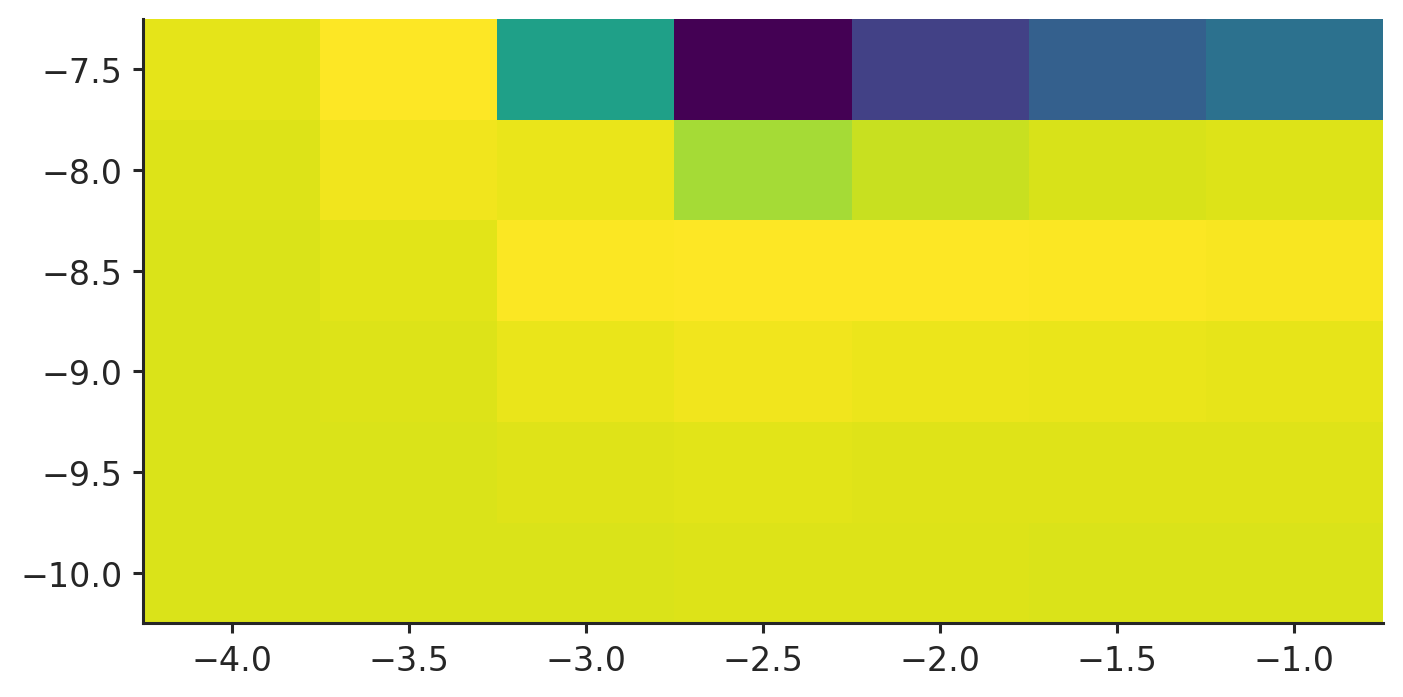

In [102]:
surface_plot(np.log10(m.t), np.log10(m.w), np.sum(ll, axis=0))

In [209]:
f2 = '../data/chrombgs_chr10_N1000_mu3.16e-09_sh0.0001_chr10_seed1107950420_rep23_dac.tsv.gz'
m.load_dacfile(f2, load_bed_ranges('../data/annotation/neutral_chr10.bed'))

0 sites in non-neutral regions skipped.


In [190]:
pi0_grid = np.logspace(-5, -3, 20)

In [215]:
llc, pi0c = m.loglikelihood(pi0_grid=pi0_grid, method='classic')
ll, pi0 = m.loglikelihood(pi0_grid=pi0_grid)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.30it/s]


(<Figure size 1600x800 with 1 Axes>, <AxesSubplot:>)

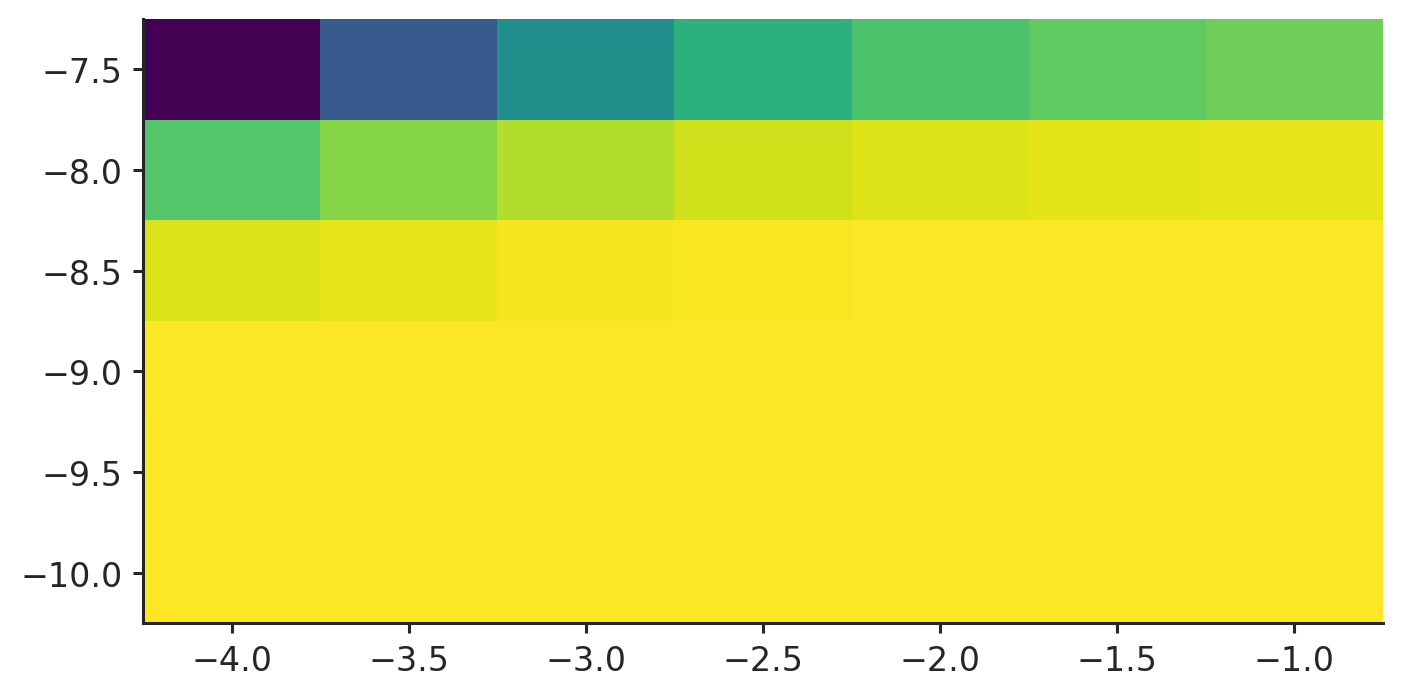

In [216]:
surface_plot(np.log10(m.t), np.log10(m.w), np.sum(llc, axis=0))

(<Figure size 1600x800 with 1 Axes>, <AxesSubplot:>)

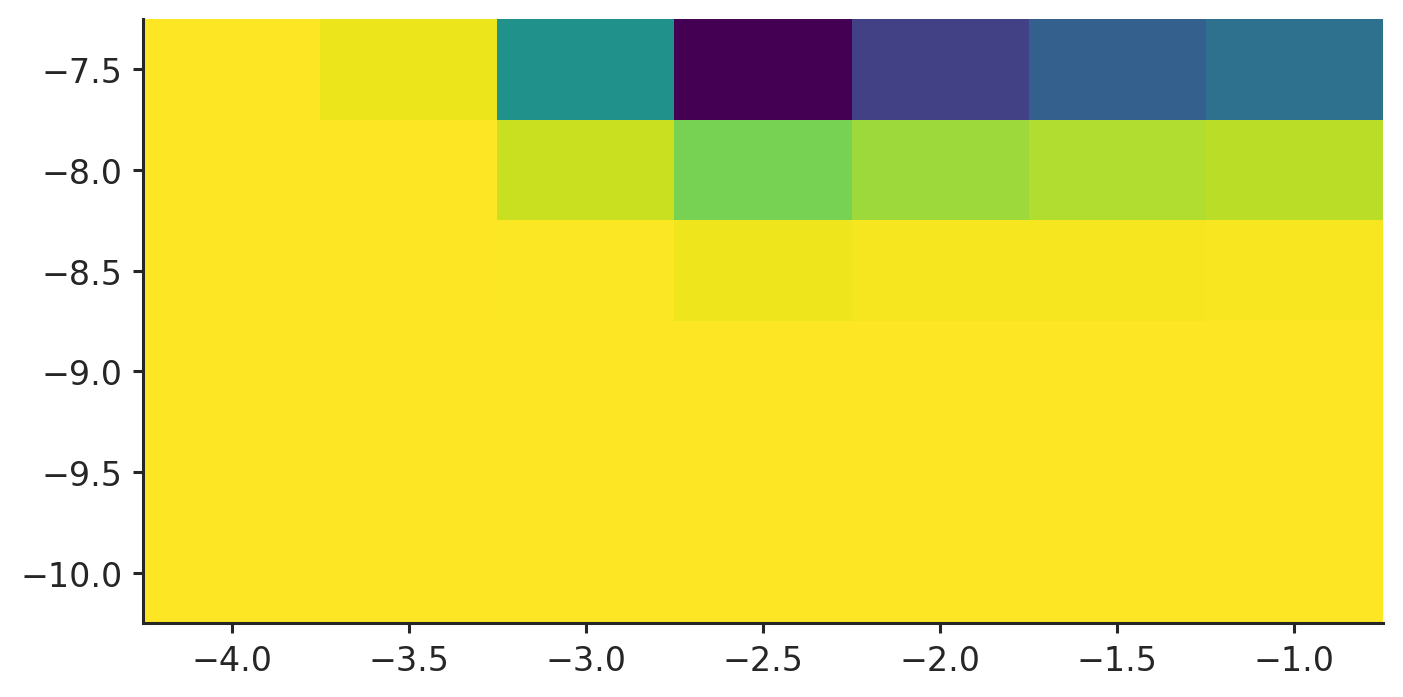

In [217]:
surface_plot(np.log10(m.t), np.log10(m.w), np.sum(ll, axis=0))

In [218]:
pi0, pi0c

(0.0006158482110660261, 0.0006158482110660261)

In [219]:
from bgspy.utils import bin_chrom
import tskit
ts = tskit.load('../data/chrombgs_chr10_N1000_mu3.16e-09_sh0.0001_chr10_seed1107950420_rep23_treeseq.tree')

In [231]:
bins = bin_chrom(ts.sequence_length+1, 1_000_000)
#ts.diversity(windows=bins, mode='branch')

In [232]:
ts.diversity()

array(8.64303173e-06)

In [256]:
np.where(ll.sum(axis=0) == np.min(ll.sum(axis=0)))

(array([5]), array([3]))

In [257]:
len(list(ts.mutations()))

11372

[3.16e-09] [0.0316]


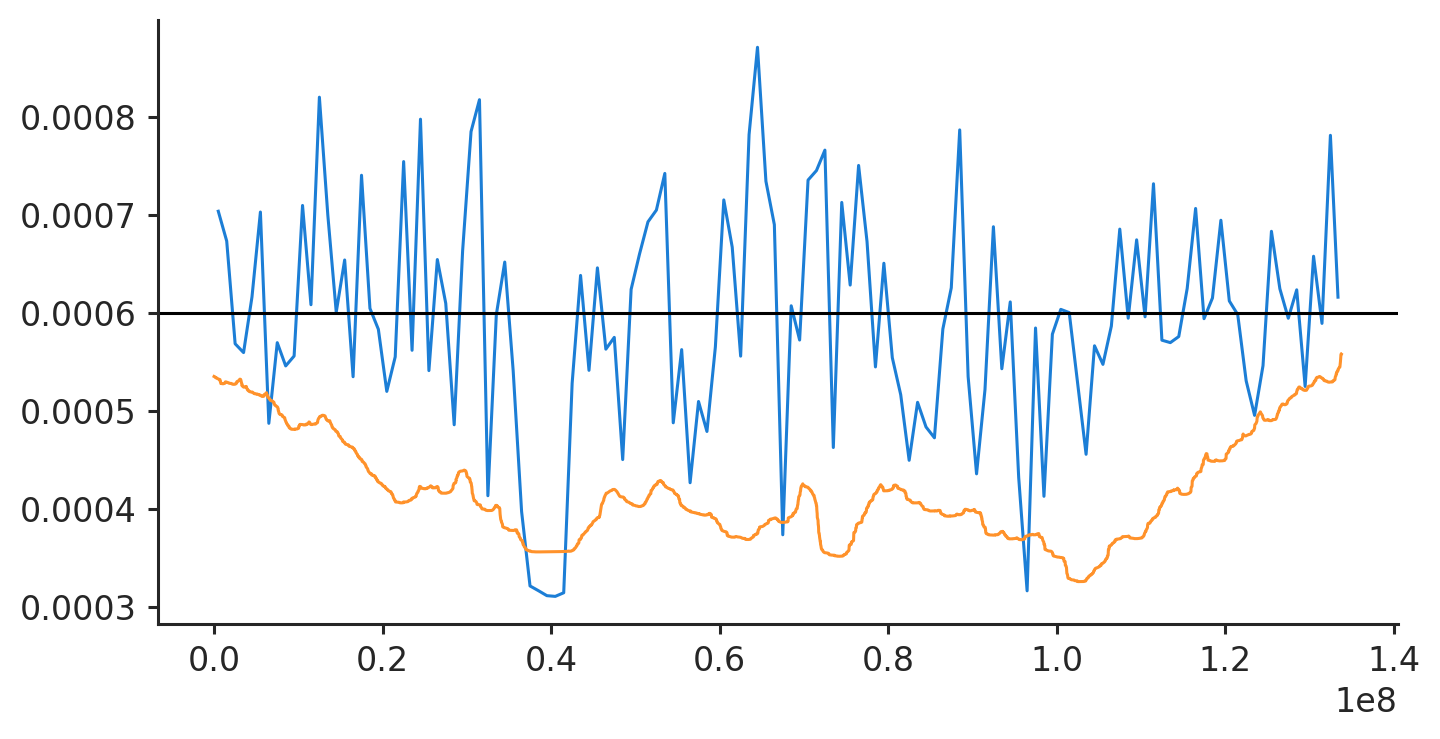

In [260]:
wi, ti = np.where(ll.sum(axis=0) == np.min(ll.sum(axis=0)))

mu = m.w[ti]
sh = m.t[wi]
print(mu, sh)
x, y = bp['chr10', mu, sh]

nmu = 1.5e-7
N = 1000

plt.plot(0.5*(bins[1:] + bins[:-1]), nmu*ts.diversity(windows=bins, mode='branch'))
#plt.plot(x, y * pi0)
#x, y = sims_means['chr10', mu, sh]
plt.plot(x, y*pi0)
plt.axhline(4*N*nmu, c='k')

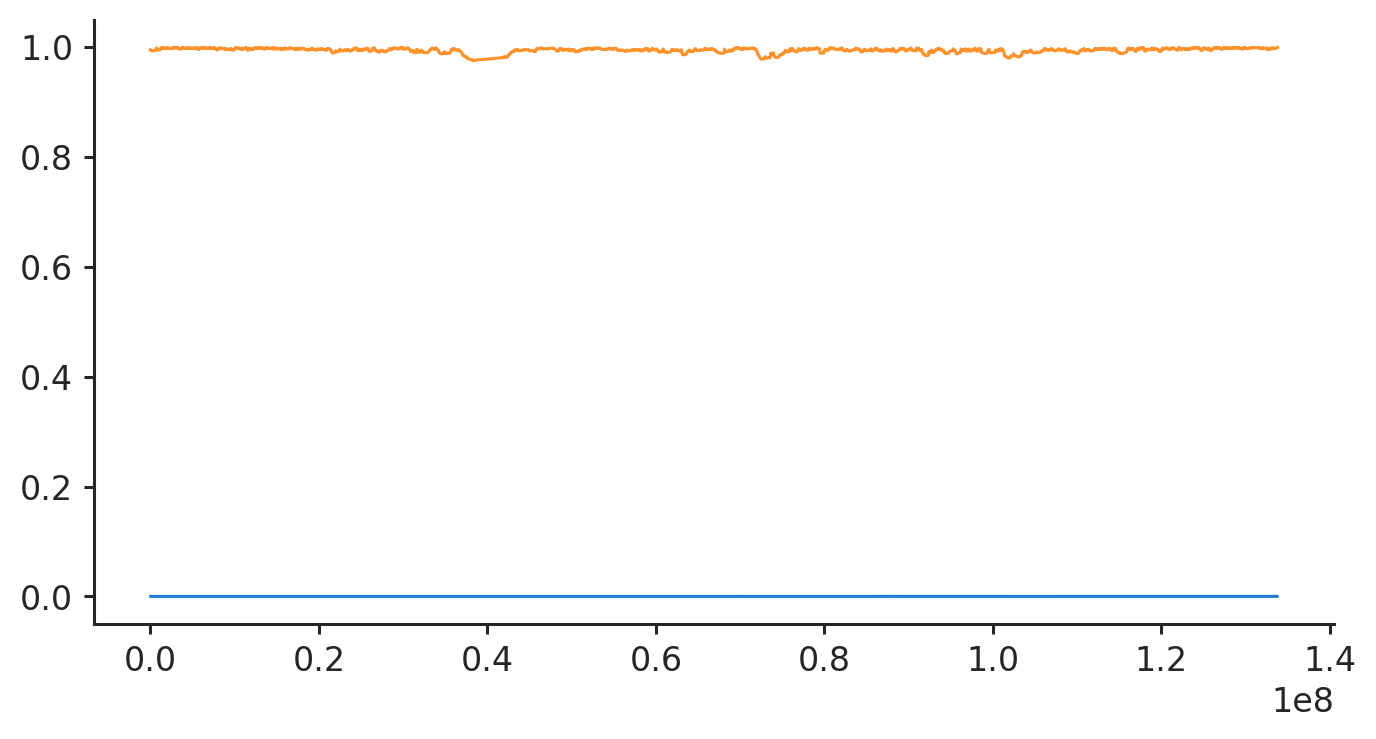

In [225]:
mu = m.w[3]
sh = m.t[0]
x, y = bp['chr10', mu, sh]

plt.plot(0.5*(bins[1:] + bins[:-1]), ts.diversity(windows=bins))
plt.plot(x, y)

In [188]:
m.w, m.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

In [170]:
ts.diversity()

array(8.64303173e-06)

In [155]:
chrom_plot(m.loglikelihood(pi0=pi0), 'chr10')

ValueError: not enough values to unpack (expected 15, got 2)